In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset/', output=dir_path, ratio=(0.85, 0.15))

Copying files: 8949 files [00:00, 12938.23 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 128
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 7605 images belonging to 2 classes.
Found 1344 images belonging to 2 classes.


In [5]:
classes_count = np.bincount(train.classes)

In [6]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = classes_count[0] + classes_count[1]
weight_for_0 = (1 / classes_count[0])*(total)/2.0 
weight_for_1 = (1 / classes_count[1])*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.13
Weight for class 1: 0.89


## View some data

In [7]:
num_classes = 4

model = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           520       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [10]:
epochs=175
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs,
  class_weight=class_weight
)

Epoch 1/175
60/60 [==============================] - 2s 14ms/step - loss: 1.0650 - accuracy: 0.4643 - val_loss: 0.8080 - val_accuracy: 0.4598
Epoch 2/175
60/60 [==============================] - 1s 16ms/step - loss: 0.8121 - accuracy: 0.5002 - val_loss: 0.7817 - val_accuracy: 0.5565
Epoch 3/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7891 - accuracy: 0.5037 - val_loss: 0.7706 - val_accuracy: 0.5469
Epoch 4/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7746 - accuracy: 0.5111 - val_loss: 0.7630 - val_accuracy: 0.5446
Epoch 5/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7629 - accuracy: 0.5218 - val_loss: 0.7656 - val_accuracy: 0.4427
Epoch 6/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7587 - accuracy: 0.5019 - val_loss: 0.7439 - val_accuracy: 0.5588
Epoch 7/175
60/60 [==============================] - 1s 16ms/step - loss: 0.7518 - accuracy: 0.5203 - val_loss: 0.7393 - val_accuracy: 0.5565
Epoch 

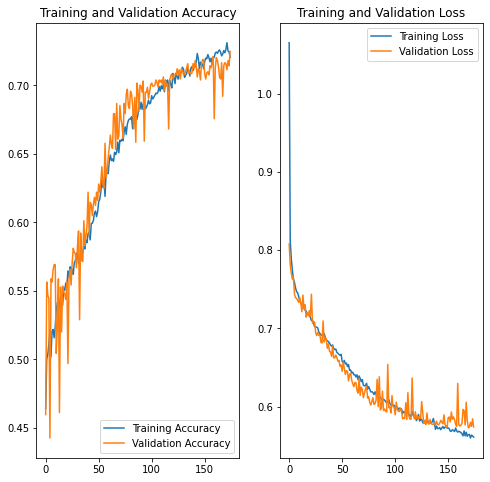

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

11/11 [==============================] - 0s 12ms/step - loss: 0.5741 - accuracy: 0.7247
Test accuracy : 0.7247023582458496


In [13]:
y_pred = model.predict(test).argmax(axis=-1)
y_true = test.classes

m = tf.keras.metrics.Precision()
m.update_state(y_pred, y_true)
print("Precision: " , m.result().numpy())

m = tf.keras.metrics.Recall()
m.update_state(y_pred, y_true)
print("Recall: " , m.result().numpy())

Precision:  0.6258322
Recall:  0.5601907


In [14]:
tf.math.confusion_matrix(y_pred, y_true)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[224, 281],
       [369, 470]], dtype=int32)>

In [15]:
# Save the weights model.
model.save('./data/humanModel/model_v2.h5')

In [16]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [17]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

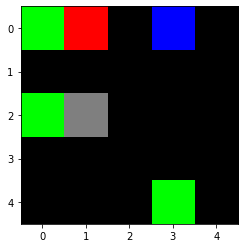

This image most likely belongs to closest_bush with a 53.05 percent confidence.
True class is follow_stag.


In [52]:
import glob

classes = ['closest_bush', 'follow_stag']
random_class = random.choice(classes)

path = "./data/humanModel/dataset_split/val/"+random_class
all_images_path = glob.glob(path + "/*.png")
random_path = random.choice(all_images_path)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(random_path)
imgplot = plt.imshow(img)
plt.show()

img = keras.preprocessing.image.load_img(
    random_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255

predictions = model.predict(img_array)[0]


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(predictions)], 100 * np.max(predictions))
)
print("True class is {}.".format(random_class))